In [1]:
#!pip install torchmetrics

In [2]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
#metricas
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import pyiqa

from model.tranfAdvModel import SRTransG
from model.discriminatorVITModel import ViTDiscriminator

from collections import Counter
import pickle
import time
import random

In [3]:
def make_loader_from_split(pickle_path,
                           hr_dir, lr_dir,
                           suffix="x2", hr_size=(128,128)):
    """
    Reconstruye los DataLoaders de entrenamiento y validación a partir
    de un pickle con las listas de splits, y devuelve además esas listas.

    Args:
        pickle_path (str): Ruta al pickle con {'train': [...], 'val': [...]}.
        hr_dir (str): Carpeta con imágenes HR.
        lr_dir (str): Carpeta con imágenes LR.
        suffix (str): Sufijo de las LR.
        hr_size (tuple): Tamaño deseado de las HR.
        batch_size (int): Tamaño de batch.
        shuffle (bool): Si barajar el set de entrenamiento.
        num_workers (int): Número de workers para DataLoader.

    Returns:
        train_loader (DataLoader): DataLoader de entrenamiento.
        val_loader (DataLoader): DataLoader de validación.
        train_hr (List[str]): Lista de nombres base del split de entrenamiento.
        val_hr (List[str]): Lista de nombres base del split de validación.
    """
    # Cargamos las listas de nombres desde el pickle
    with open(pickle_path, "rb") as f:
        split = pickle.load(f)
    train_hr = split["train"]
    val_hr   = split["val"]


    to_tensor = transforms.ToTensor()
    def make_dataset(hr_list):
        hr_tensors, lr_tensors = [], []
        for hr_fn in hr_list:
            lr_fn = hr_fn.replace(".png", suffix+".png")
            hr = Image.open(os.path.join(hr_dir, hr_fn)).convert('RGB')
            lr = Image.open(os.path.join(lr_dir, lr_fn)).convert('RGB')
            hr_tensors.append(to_tensor(hr))
            lr_tensors.append(to_tensor(lr))
        return torch.stack(lr_tensors), torch.stack(hr_tensors)


    lr_train, hr_train = make_dataset(train_hr)
    lr_val,   hr_val   = make_dataset(val_hr)
    
    train_dataset = TensorDataset(lr_train, hr_train)
    val_dataset   = TensorDataset(lr_val,   hr_val)

    return train_dataset, val_dataset, train_hr, val_hr

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# 1. Configuración
# ──────────────────────────────────────────────────────────────────────────────
dataset_dir    = "Datasets/"

hr_train_dir = os.path.join(dataset_dir, "SatImages/perusat_v5_rgb/HR/")
lr_train_dir = os.path.join(dataset_dir, "SatImages/perusat_v5_rgb/LR_BICUBIC/X2/")
suffix       = "_x2"
hr_size      = (512, 512)
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# 2. Cargar splits
# ──────────────────────────────────────────────────────────────────────────────
model_save_dir = os.path.join("G:/MaestriaInformatica/Tesis/Outputs/TransfAdv_Sat/", "models/")

splits_pkl = os.path.join(model_save_dir, "splits.pkl")

# ──────────────────────────────────────────────────────────────────────────────
# 3. Recrear DataLoaders
# ──────────────────────────────────────────────────────────────────────────────
train_dataset, val_dataset, train_hr, val_hr = make_loader_from_split(
        splits_pkl,
        hr_train_dir, lr_train_dir,
        suffix="_x2", hr_size=(512,512)
    )
# Crear DataLoader (batch size pequeño para ahorrar memoria)
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

lr_all, hr_all = train_loader.dataset.tensors

print("Dataset HR (CPU):", hr_all.shape)
print("Dataset LR (CPU):", lr_all.shape)

Dataset HR (CPU): torch.Size([2349, 3, 512, 512])
Dataset LR (CPU): torch.Size([2349, 3, 256, 256])


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# 4. Función de evaluación
# ──────────────────────────────────────────────────────────────────────────────
class CUDAPrefetcher:
    def __init__(self, loader, device):
        self.loader = iter(loader)
        self.device = device
        self.stream = torch.cuda.Stream()
        self.preload()

    def preload(self):
        try:
            self.next_lr, self.next_hr = next(self.loader)
        except StopIteration:
            self.next_lr = self.next_hr = None
            return
        # kick off an async copy on its own stream
        with torch.cuda.stream(self.stream):
            self.next_lr = self.next_lr.to(self.device, non_blocking=True)
            self.next_hr = self.next_hr.to(self.device, non_blocking=True)

    def next(self):
        # wait for the copy to finish before using
        torch.cuda.current_stream().wait_stream(self.stream)
        lr, hr = self.next_lr, self.next_hr
        if lr is None:
            return None, None
        # start loading the *next* batch in the background
        self.preload()
        return lr, hr

def evaluate_dataset(generator, data_loader, device):
    generator.eval()

    # initialize metrics as before...
    psnr_pyiqa = pyiqa.create_metric('psnr', device=device)
    ssim_pyiqa = pyiqa.create_metric('ssimc', device=device)
    psnr_tcm  = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_tcm  = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    total_psnr_pyiqa = total_ssim_pyiqa = 0.0
    total_psnr_ski  = total_ssim_ski   = 0.0
    count_pyiqa = count_ski = 0

    # wrap your loader in the prefetcher
    prefetcher = CUDAPrefetcher(data_loader, device)

    # batch-level copy + joblib parallel as before
    from joblib import Parallel, delayed

    def _skimage_pair(hr_np, sr_np):
        p = peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0)
        h, w, _ = hr_np.shape
        win = min(7, h, w)
        if win % 2 == 0: win -= 1
        win = max(win, 3)
        s = structural_similarity(hr_np, sr_np,
                                  data_range=1.0,
                                  channel_axis=2,
                                  win_size=win)
        return p, s

    with torch.no_grad():
        while True:
            lr, hr = prefetcher.next()
            if lr is None:
                break
            # 1) run generator
            sr = generator(lr)

            # 2) pyiqa (batch)
            bp = psnr_pyiqa(hr, sr).mean().item()
            bs = ssim_pyiqa(hr, sr).mean().item()
            total_psnr_pyiqa += bp * hr.size(0)
            total_ssim_pyiqa += bs * hr.size(0)
            count_pyiqa       += hr.size(0)

            # 3) scikit-image via batch-level CPU copy + parallel
            sr_np = sr.permute(0,2,3,1).cpu().numpy().clip(0,1)
            hr_np = hr.permute(0,2,3,1).cpu().numpy().clip(0,1)
            results = Parallel(n_jobs=-1)(
                delayed(_skimage_pair)(hr_np[i], sr_np[i])
                for i in range(hr_np.shape[0])
            )
            for p, s in results:
                total_psnr_ski  += p
                total_ssim_ski  += s
            count_ski += hr_np.shape[0]

            # 4) torchmetrics accumulate
            psnr_tcm.update(sr, hr)
            ssim_tcm.update(sr, hr)

    # finalize
    avg_pyiqa_psnr = total_psnr_pyiqa / count_pyiqa
    avg_pyiqa_ssim = total_ssim_pyiqa / count_pyiqa
    avg_ski_psnr   = total_psnr_ski  / count_ski
    avg_ski_ssim   = total_ssim_ski  / count_ski
    avg_tcm_psnr   = psnr_tcm.compute().item()
    avg_tcm_ssim   = ssim_tcm.compute().item()

    return (
        avg_pyiqa_psnr, avg_pyiqa_ssim,
        avg_ski_psnr,   avg_ski_ssim,
        avg_tcm_psnr,   avg_tcm_ssim,
    )

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# 5. Iterar sobre checkpoints y recolectar métricas
# ──────────────────────────────────────────────────────────────────────────────

#output_dir_list=["G:/MaestriaInformatica/Tesis/Outputs/TransfAdv_Sat/","G:/MaestriaInformatica/Tesis/Outputs/Transf/"]
output_dir_list=["G:/MaestriaInformatica/Tesis/Outputs/Transf/"]
for output_dir in output_dir_list:
    print(f"Procsando para {output_dir}") 
    sample_test_output_dir = os.path.join(output_dir, "samples/")
    
    model_save_dir = os.path.join(output_dir, "models/")
    
    ckpts = sorted([
        fn for fn in os.listdir(model_save_dir)
        if fn.startswith("generator_EP") and fn.endswith(".pth")
    ])
    
    # Parámetros de tu modelo
    gen_kwargs = dict(
        input_dim=3
        embed_dim=16,
        patch_size=64,
        token_dim = 512,
        num_levels=3, 
        num_refinement=1,
        encoder_transformer_blocks=[4,6,6],
        decoder_transformer_blocks=[4,4,6],
        refinement_transformer_blocks=[4]
    )
    
    random.seed(42)
    sample_indices = random.sample(range(len(val_dataset)), 10)
    sample_names   = [val_hr[i] for i in sample_indices] 
    
    os.makedirs(sample_test_output_dir, exist_ok=True)
    
    epochs    = []
    #PSNR y SSIM - pyiqa
    pyiqa_psnr_tr   = [] 
    pyiqa_ssim_tr   = []
    pyiqa_psnr_val  = []
    pyiqa_ssim_val  = []
    #PSNR y SSIM - skimage
    skimage_psnr_tr   = []
    skimage_ssim_tr   = []
    skimage_psnr_val  = []
    skimage_ssim_val  = []
    #PSNR y SSIM - torchimage
    trchimg_psnr_tr   = []
    trchimg_ssim_tr   = []
    trchimg_psnr_val  = []
    trchimg_ssim_val  = []
    
    
    start_total = time.time()
    print(f"Start")
    for ckpt in ckpts:
        epoch_start = time.time()
        ep = int(ckpt.split("EP")[1].split(".")[0])
        
        # montar modelo y cargar pesos
        net = SRTransG(**gen_kwargs).to(device)
        net.load_state_dict(torch.load(os.path.join(model_save_dir, ckpt), map_location=device))
            
        # evaluar    
        epochs.append(ep)
    
        #print(f"Generating metrics")
        py_tr_psnr, py_tr_ssim, sk_tr_psnr, sk_tr_ssim, tci_tr_psnr, tci_tr_ssim = evaluate_dataset(net, train_loader, device)
        py_va_psnr, py_va_ssim, sk_va_psnr, sk_va_ssim, tci_va_psnr, tci_va_ssim = evaluate_dataset(net, val_loader, device)
        #pyiqa
        pyiqa_psnr_tr.append(py_tr_psnr)
        pyiqa_ssim_tr.append(py_tr_ssim)
        pyiqa_psnr_val.append(py_va_psnr)
        pyiqa_ssim_val.append(py_va_ssim)
        #skimage    
        skimage_psnr_tr.append(sk_tr_psnr)
        skimage_ssim_tr.append(sk_tr_ssim)
        skimage_psnr_val.append(sk_va_psnr)
        skimage_ssim_val.append(sk_va_ssim)    
        #torchimage    
        trchimg_psnr_tr.append(tci_tr_psnr)
        trchimg_ssim_tr.append(tci_tr_ssim)
        trchimg_psnr_val.append(tci_va_psnr)
        trchimg_ssim_val.append(tci_va_ssim)
    
    
        elapsed = time.time() - epoch_start
        mins, secs = divmod(int(elapsed), 60)
        total_elapsed = time.time() - start_total
        t_m, t_s = divmod(int(total_elapsed), 60)
        m, s = divmod(int(elapsed), 60)
        
        print(f"Epoch {ep:02d} Time_Epoch: {mins}m{secs}s, Time_Total: {t_m}m{t_s}s")
        print(f"\tTrain pyiqa-PSNR: {py_tr_psnr:.4f} | skimage-PSNR: {sk_tr_psnr:.4f} | trchimg-PSNR: {tci_tr_psnr:.4f} | pyiqa-SSIM: {py_tr_ssim:.4f} | skimage-SSIM: {sk_tr_ssim:.4f} | trchimg-SSIM: {tci_tr_ssim:.4f}")
        print(f"\tVal pyiqa-PSNR: {py_va_psnr:.4f} | skimage-PSNR: {sk_va_psnr:.4f} | trchimg-PSNR: {tci_va_psnr:.4f} | pyiqa-SSIM: {py_va_ssim:.4f} | skimage-SSIM: {sk_va_ssim:.4f} | trchimg-SSIM: {tci_va_ssim:.4f}")
    
        #with torch.no_grad():
            #for idx, name in zip(sample_indices, sample_names):
                # Extraer par LR y generar SR
                #lr_img = val_dataset[idx][0].unsqueeze(0).to(device)  # tensor LR
                #sr_img = net(lr_img)                                  # salida SR
    
                # Convertir a uint8 y guardar
                #sr_np   = sr_img[0].cpu().permute(1,2,0).numpy().clip(0,1)
                #sr_uint8 = (sr_np * 255).astype(np.uint8)
                #out_path = f"{sample_test_output_dir}{name}_EP{ep:02d}.png"
                #Image.fromarray(sr_uint8).save(out_path)  
        history_train_val=dict()
        history_train_val["pyiqa_psnr_tr"] = pyiqa_psnr_tr
        history_train_val["pyiqa_ssim_tr"] = pyiqa_ssim_tr
        history_train_val["pyiqa_psnr_val"] = pyiqa_psnr_val
        history_train_val["pyiqa_ssim_val"] = pyiqa_ssim_val
        history_train_val["skimage_psnr_tr"] = skimage_psnr_tr
        history_train_val["skimage_ssim_tr"] = skimage_ssim_tr
        history_train_val["skimage_psnr_val"] = skimage_psnr_val
        history_train_val["skimage_ssim_val"] = skimage_ssim_val
        history_train_val["trchimg_psnr_tr"] = trchimg_psnr_tr
        history_train_val["trchimg_ssim_tr"] = trchimg_ssim_tr
        history_train_val["trchimg_psnr_val"] = trchimg_psnr_val
        history_train_val["trchimg_ssim_val"] = trchimg_ssim_val
        with open( model_save_dir+"historyTrainVal.pkl", "wb") as f:
            pickle.dump({"historyTrainVal": history_train_val}, f)
    print(f"End")

Procsando para G:/MaestriaInformatica/Tesis/Outputs/Transf/
Start


C:\Users\victo\AppData\Local\Temp\ipykernel_19764\233351448.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(os.path.join(model_save_dir, 

Epoch 01 Time_Epoch: 1m33s, Time_Total: 1m33s
	Train pyiqa-PSNR: 25.2930 | skimage-PSNR: 25.4714 | trchimg-PSNR: 25.2116 | pyiqa-SSIM: 0.4037 | skimage-SSIM: 0.4290 | trchimg-SSIM: 0.4026
	Val pyiqa-PSNR: 25.2595 | skimage-PSNR: 25.4483 | trchimg-PSNR: 25.1743 | pyiqa-SSIM: 0.3990 | skimage-SSIM: 0.4241 | trchimg-SSIM: 0.3980
Epoch 02 Time_Epoch: 1m41s, Time_Total: 3m15s
	Train pyiqa-PSNR: 31.9935 | skimage-PSNR: 32.0332 | trchimg-PSNR: 31.6314 | pyiqa-SSIM: 0.8004 | skimage-SSIM: 0.8116 | trchimg-SSIM: 0.7950
	Val pyiqa-PSNR: 32.0245 | skimage-PSNR: 32.0676 | trchimg-PSNR: 31.6479 | pyiqa-SSIM: 0.7978 | skimage-SSIM: 0.8090 | trchimg-SSIM: 0.7925
Epoch 03 Time_Epoch: 1m10s, Time_Total: 4m26s
	Train pyiqa-PSNR: 33.6573 | skimage-PSNR: 33.6989 | trchimg-PSNR: 33.3283 | pyiqa-SSIM: 0.8356 | skimage-SSIM: 0.8455 | trchimg-SSIM: 0.8325
	Val pyiqa-PSNR: 33.5796 | skimage-PSNR: 33.6253 | trchimg-PSNR: 33.2411 | pyiqa-SSIM: 0.8326 | skimage-SSIM: 0.8426 | trchimg-SSIM: 0.8296
Epoch 04 Time_Ep

In [32]:
output_dir_list=["G:/MaestriaInformatica/Tesis/Outputs/Transf/"]
for output_dir in output_dir_list:
    print(f"Procsando para {output_dir}") 
    sample_test_output_dir = os.path.join(output_dir, "samples/")
    
    model_save_dir = os.path.join(output_dir, "models/")
    
    ckpts = sorted([
        fn for fn in os.listdir(model_save_dir)
        if fn.startswith("generator_EP") and fn.endswith("84.pth")
    ])
    
    # Parámetros de tu modelo
    gen_kwargs = dict(
        embed_dim=16,
        patch_size=64,
        token_dim = 512,
        num_levels=3, 
        num_refinement=1,
        encoder_transformer_blocks=[4,6,6],
        decoder_transformer_blocks=[4,4,6],
        refinement_transformer_blocks=[4]
    )
    
    random.seed(5)
    sample_indices = random.sample(range(len(val_dataset)), 10)
    sample_names   = [val_hr[i] for i in sample_indices] 
    
    os.makedirs(sample_test_output_dir, exist_ok=True)
            
    print(f"Start")
    for ckpt in ckpts:
        
     
        with torch.no_grad():
            for idx, name in zip(sample_indices, sample_names):
                # Extraer par LR y generar SR
                lr_img = val_dataset[idx][0].unsqueeze(0).to(device)  # tensor LR
                sr_img = net(lr_img)                                  # salida SR
    
                # Convertir a uint8 y guardar
                sr_np   = sr_img[0].cpu().permute(1,2,0).numpy().clip(0,1)
                sr_uint8 = (sr_np * 255).astype(np.uint8)
                out_path = f"{sample_test_output_dir}{name}_EP{ep:02d}.png"
                Image.fromarray(sr_uint8).save(out_path)          
    print(f"End")

Procsando para G:/MaestriaInformatica/Tesis/Outputs/Transf/
Start
End


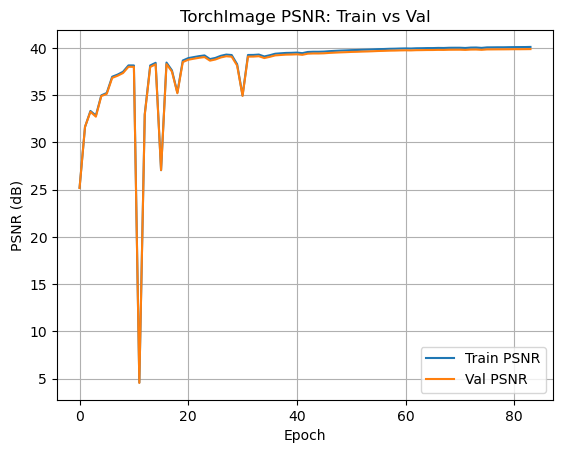

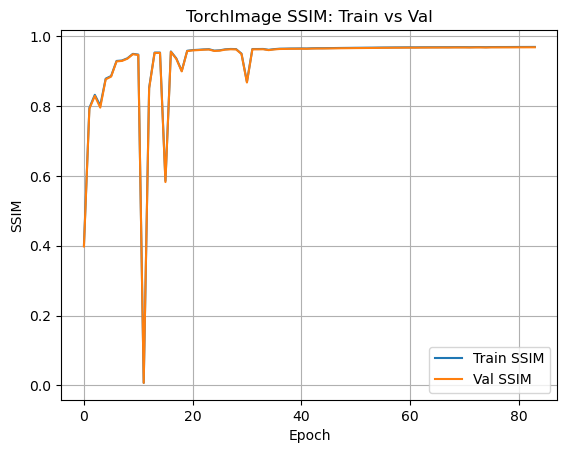

In [9]:
import pickle
import os
import matplotlib.pyplot as plt

output_dir="G:/MaestriaInformatica/Tesis/Outputs/Transf/"
model_save_dir = os.path.join(output_dir, "models/")

# Ruta al archivo .pkl
pkl_path = model_save_dir+"historyTrainVal.pkl"  # Reemplaza con la ruta real

# Cargar el archivo
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

# Obtener el diccionario de métricas
history = data["historyTrainVal"]

# Extraer los valores de PSNR y SSIM (torchimage)
psnr_tr = history["trchimg_psnr_tr"]
psnr_val = history["trchimg_psnr_val"]
ssim_tr = history["trchimg_ssim_tr"]
ssim_val = history["trchimg_ssim_val"]

# Graficar PSNR
plt.figure()
plt.plot(psnr_tr, label="Train PSNR")
plt.plot(psnr_val, label="Val PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("TorchImage PSNR: Train vs Val")
plt.legend()
plt.grid(True)
plt.show()

# Graficar SSIM
plt.figure()
plt.plot(ssim_tr, label="Train SSIM")
plt.plot(ssim_val, label="Val SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("TorchImage SSIM: Train vs Val")
plt.legend()
plt.grid(True)
plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 6. Graficar PSNR y SSIM lado a lado
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

# --- Fila 0: PSNR ---

# Col 0: pyiqa
ax = axes[0, 0]
ax.plot(epochs, pyiqa_psnr_tr,  label="Train", marker="o")
ax.plot(epochs, pyiqa_psnr_val, label="Val",   marker="o")
ax.set_title("PSNR (pyiqa)")
ax.set_ylabel("PSNR (dB)")
ax.legend()
ax.grid(True)

# Col 1: skimage
ax = axes[0, 1]
ax.plot(epochs, skimage_psnr_tr,  label="Train", marker="s")
ax.plot(epochs, skimage_psnr_val, label="Val",   marker="s")
ax.set_title("PSNR (skimage)")
ax.legend()
ax.grid(True)

# Col 2: torchmetrics
ax = axes[0, 2]
ax.plot(epochs, trchimg_psnr_tr,  label="Train", marker="^")
ax.plot(epochs, trchimg_psnr_val, label="Val",   marker="^")
ax.set_title("PSNR (torchmetrics)")
ax.legend()
ax.grid(True)

# --- Fila 1: SSIM ---

# Col 0: pyiqa
ax = axes[1, 0]
ax.plot(epochs, pyiqa_ssim_tr,  label="Train", marker="o")
ax.plot(epochs, pyiqa_ssim_val, label="Val",   marker="o")
ax.set_title("SSIM (pyiqa)")
ax.set_xlabel("Época")
ax.set_ylabel("SSIM")
ax.legend()
ax.grid(True)

# Col 1: skimage
ax = axes[1, 1]
ax.plot(epochs, skimage_ssim_tr,  label="Train", marker="s")
ax.plot(epochs, skimage_ssim_val, label="Val",   marker="s")
ax.set_title("SSIM (skimage)")
ax.set_xlabel("Época")
ax.legend()
ax.grid(True)

# Col 2: torchmetrics
ax = axes[1, 2]
ax.plot(epochs, trchimg_ssim_tr,  label="Train", marker="^")
ax.plot(epochs, trchimg_ssim_val, label="Val",   marker="^")
ax.set_title("SSIM (torchmetrics)")
ax.set_xlabel("Época")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()